<a href="https://colab.research.google.com/github/Tstrebe2/umich-mads-capstone-project/blob/main/models/densenet/tim-ft-densenet-v1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

# !{sys.executable} -m pip install pydicom -q
!{sys.executable} -m pip install torchmetrics -q

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/capstone/assets/stage_2_train_images.zip'
!mkdir -p /content/images
!unzip -qq {path} -d /content/images

In [1]:
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
import torchvision
import torchmetrics

import pydicom as dicom
from PIL import Image

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import copy

In [2]:
class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, indices=None, transform=None, target_transform=None):
    if indices:
      self.img_labels = pd.read_csv(annotations_file).iloc[indices]
    else:
      self.img_labels = pd.read_csv(annotations_file)

    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = ''.join([os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]), '.dcm'])
    
    image = dicom.dcmread(img_path)
    image = Image.fromarray(image.pixel_array)

    label = self.img_labels.iloc[idx, -1]

    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

In [3]:
annotations_file = '/content/drive/MyDrive/capstone/assets/stage_2_train_labels.csv.zip'
img_dir = '/content/images'

label_df = pd.read_csv(annotations_file).groupby('patientId').first().reset_index()

X_train, X_test = train_test_split(label_df, test_size=.2, stratify=label_df.Target, random_state=99)
X_val, X_test, = train_test_split(X_test, test_size=.5, stratify=X_test.Target, random_state=99)
X_train, X_val, X_test = X_train.index.tolist(), X_val.index.tolist(), (X_test.index.tolist())

len(X_train), len(X_val),  len(X_test)

(21347, 2668, 2669)

In [4]:
mean = [0.5173]
std = [0.2167]

transforms = dict(
  train = torchvision.transforms.Compose([
      torchvision.transforms.RandomHorizontalFlip(),
      torchvision.transforms.RandomRotation((-5, 5)),
      torchvision.transforms.Resize(256),
      torchvision.transforms.CenterCrop(224),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean, std),
  ]),
  val = torchvision.transforms.Compose([
      torchvision.transforms.Resize(256),
      torchvision.transforms.CenterCrop(224),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean, std),
  ])
)

target_transforms = torchvision.transforms.Compose([
  torch.tensor,
  partial(F.one_hot, num_classes=2),
])

datasets = dict(
    train=CustomImageDataset(annotations_file, img_dir, indices=X_train, transform=transforms['train'], target_transform=target_transforms),
    val=CustomImageDataset(annotations_file, img_dir, indices=X_val, transform=transforms['val'], target_transform=target_transforms),
    test=CustomImageDataset(annotations_file, img_dir, indices=X_test, transform=transforms['val'], target_transform=target_transforms),
)

In [5]:
batch_size = 32

data_loaders = dict(
    train=DataLoader(datasets['train'], batch_size=batch_size, shuffle=True),
    val=DataLoader(datasets['val'], batch_size=batch_size, shuffle=True),
    test=DataLoader(datasets['test'], batch_size=batch_size),
)

dataset_sizes = {x:len(datasets[x]) for x in ('train', 'val', 'test')}

print('training steps per epoch:', dataset_sizes['train']//batch_size)
print('validation steps per epoch:', dataset_sizes['val']//batch_size)
print('test steps per epoch:', dataset_sizes['test']//batch_size)

training steps per epoch: 667
validation steps per epoch: 83
test steps per epoch: 83


In [ ]:
# Uncomment and run to get mean and standard deviation
# for x, y in data_loaders['train']:
#   break

# x.mean(), x.std()

In [6]:
model = torchvision.models.densenet121(weights='DEFAULT')
# Change first layer to from 3 channel input to 1.
model.features.conv0 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# Lets start by freezing the layers so that we only tune our classifier.
for param in model.parameters():
  param.requires_grad = False
# add final layer with # outputs in same dimension of labels
# these layers will have params.requires_grad=True
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(model.classifier.in_features, 2))
# Now lets only add the classifier layers to the optimizer
params_to_update = []
for name, param in model.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print("\t",name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

zero, one = label_df.iloc[X_train].Target.value_counts().tolist()

criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.0, zero/one]).to(device))
optimizer = torch.optim.SGD(params_to_update, lr=1e-3, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.7)

	 classifier.0.weight
	 classifier.0.bias


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_loss = 1e+8

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs-1}')
    print('-' * 10)

    for phase in ('train', 'val'):
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for (inputs, labels) in data_loaders[phase]:
        inputs = inputs.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outputs = model(inputs)
          preds = outputs.argmax(dim=1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        # running_corrects += torch.sum(preds == labels.argmax(dim=1).data)
        print(torch.Torchme)
        break
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      lr = next(iter(optimizer.param_groups))['lr']

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} LR: {lr:6f}')

      # deep copy the model
      if phase == 'val' and epoch_loss < best_loss:
          best_loss = epoch_loss
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Loss: {best_loss:4f}')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [16]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=2)

Epoch 0/1
----------
train Loss: 0.6660 Acc: 0.7598 LR: 0.000700
val Loss: 0.6314 Acc: 0.7800 LR: 0.000700
Epoch 1/1
----------
train Loss: 0.6626 Acc: 0.7627 LR: 0.000700
val Loss: 0.6313 Acc: 0.7676 LR: 0.000700
Training complete in 12m 33s
Best val Loss: 0.631296
Best val Acc: 0.767616


In [21]:
# Save model
path = '/content/drive/MyDrive/capstone/models/tim-densenet-121-ft'

torch.save({
    'train_ix':X_train, 
    'val_ix':X_val, 
    'test_ix':X_test,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
  },
  path
)

In [9]:
# path = '/content/drive/MyDrive/capstone/models/tim-densenet-201-ft'
# model.load_state_dict(torch.load(path)['model_state_dict'])
# model = model.to(device)

In [22]:
# Lets unfreeze and fine-tune the model for a couple of epochs
for param in model.parameters():
  param.requires_grad = True

optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.2)
scheduler = StepLR(optimizer, step_size=3, gamma=0.7)

In [37]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=2)


Epoch 0/1
----------
train Loss: 0.6282 Acc: 0.7781 LR: 0.000070
val Loss: 0.6078 Acc: 0.7969 LR: 0.000070
Epoch 1/1
----------
train Loss: 0.6227 Acc: 0.7809 LR: 0.000049
val Loss: 0.6148 Acc: 0.7759 LR: 0.000049
Training complete in 17m 33s
Best val Loss: 0.607813
Best val Acc: 0.796852


In [38]:
running_labels = torch.Tensor(0, 2).to(device)
running_outputs = torch.Tensor(0, 2).to(device)

with torch.no_grad():
  model.eval()
  for i, (inputs, labels) in enumerate(data_loaders['test']):
    inputs, labels = inputs.to(device), labels.float().to(device)

    outputs = model(inputs)

    running_labels = torch.cat((running_labels, labels), dim=0)
    running_outputs = torch.cat((running_outputs, outputs), dim=0)

best threshold	0.4646
precision:	0.6623
recall:		0.7435
f1:		0.7006



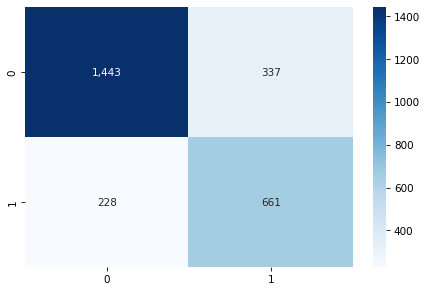

In [50]:
y_true = running_labels.argmax(dim=1).cpu().numpy()
y_proba = torch.nn.Softmax(dim=1)(running_outputs).cpu().numpy()[:, 1]

precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_proba)
f1_scores = (2 * precision * recall) / (precision + recall)
ix = np.argmax(f1_scores)
best_thresh = thresholds[ix]

y_pred = y_proba >= best_thresh #running_outputs.argmax(dim=1).cpu().numpy()

precision = metrics.precision_score(y_true, y_pred)
recall = metrics.recall_score(y_true, y_pred)
f1 = metrics.f1_score(y_true, y_pred)

print('best threshold\t{:.4f}'.format(best_thresh))
print('precision:\t{:.4f}'.format(precision))
print('recall:\t\t{:.4f}'.format(recall))
print('f1:\t\t{:.4f}'.format(f1))
print()

fig = plt.figure(dpi=75)
ax = plt.gca()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot=True, fmt=',', cmap='Blues')
fig.tight_layout()
fig.show()

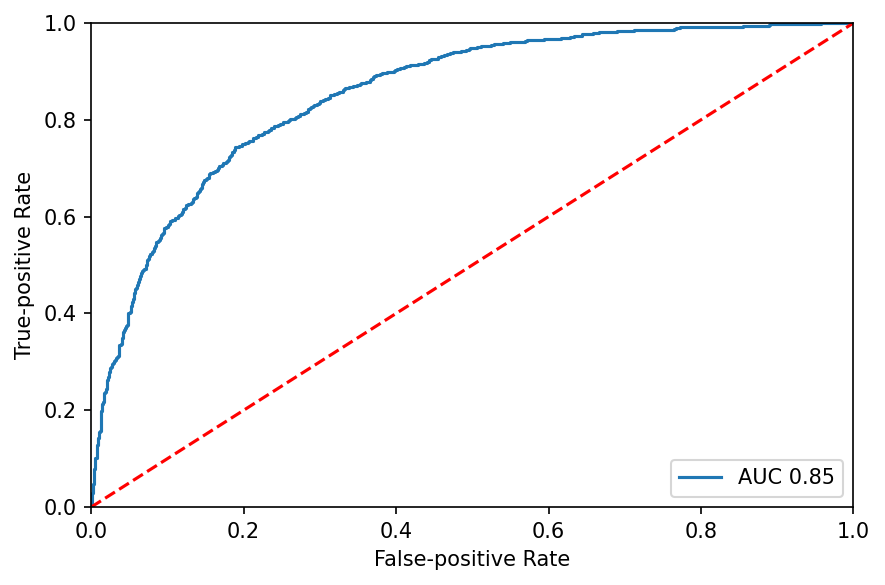

In [51]:
fpr, tpr, _ = metrics.roc_curve(y_true, y_proba)
roc_auc_score = metrics.roc_auc_score(y_true, y_proba)

no_skill = np.linspace(0, 1, 100)

plt.figure(dpi=150)
plt.plot(fpr, tpr, label='AUC {:.2f}'.format(roc_auc_score))
plt.plot(no_skill, no_skill, '--r')
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel('True-positive Rate')
plt.xlabel('False-positive Rate')
plt.tight_layout()
plt.show()

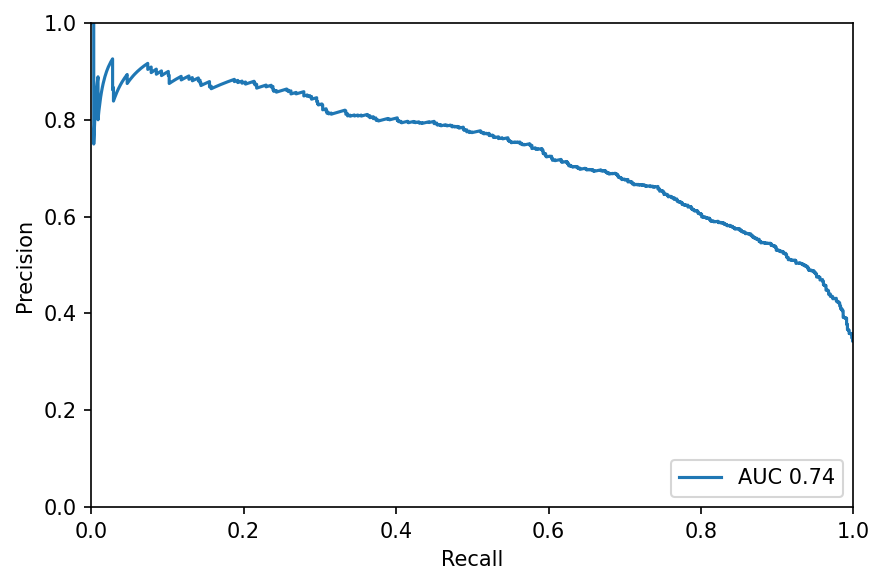

In [52]:
precision, recall, _ = metrics.precision_recall_curve(y_true, y_proba)
auprc_score = metrics.auc(recall, precision)

plt.figure(dpi=150)
plt.plot(recall, precision, label='AUC {:.2f}'.format(auprc_score))
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.tight_layout()
plt.show()

In [53]:
# Save model
path = '/content/drive/MyDrive/capstone/models/tim-densenet-121'

torch.save({
    'train_ix':X_train, 
    'val_ix':X_val, 
    'test_ix':X_test,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
  },
  path
)